# MED-PC Data Processing Notebook

## Importing the Python Libraries

In [1]:
import sys
import glob
from collections import defaultdict
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from medpc2excel.medpc_read import medpc_read

In [3]:
# setting path
sys.path.append('../../src')

In [4]:
# All the libraries that were created for this repository
import extract.dataframe
import extract.metadata
import processing.tone
import processing.port

In [5]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Loading in Recording and Metadata from Previous Notebook

# NOTE: If you changed the directory of where the MED-PC recording dataframes, then you must change the directories in the following paths

- This will get all the files in each specified path

In [6]:
concatted_medpc_files = glob.glob("./proc/extracted_recording_data_and_metadata/*/MEDPC_recording_cage_*.csv")
metadata_files = glob.glob("./proc/extracted_recording_data_and_metadata/*/metadata_cage_*.csv")
recording_and_metadata_files = glob.glob("./proc/extracted_recording_data_and_metadata/*/recording_metadata_cage_*.csv")

# NOTE: If there is more than one MED-PC recording dataframes, then you must manually change the path in the `pd.read_csv()` for the corresponding variables. Verify if this is the correct file that you want to use

In [7]:
metadata_files[0]

'./proc/extracted_recording_data_and_metadata/experiment_Pilot_of_Pilot_cage_1_2_date_20220504_20220516/metadata_cage_1_2_date_20220504_20220516.csv'

In [8]:
concatted_medpc_files[0]

'./proc/extracted_recording_data_and_metadata/experiment_Pilot_of_Pilot_cage_1_2_date_20220504_20220516/MEDPC_recording_cage_1_2_date_20220504_20220516.csv'

In [9]:
recording_and_metadata_files[0]

'./proc/extracted_recording_data_and_metadata/experiment_Pilot_of_Pilot_cage_1_2_date_20220504_20220516/recording_metadata_cage_1_2_date_20220504_20220516.csv'

In [10]:
metadata_df = pd.read_csv(metadata_files[0], index_col=0)
concatted_medpc_df = pd.read_csv(concatted_medpc_files[0], index_col=0)
recording_and_metadata_df = pd.read_csv(recording_and_metadata_files[0], index_col=0)

- The Dataframe the contains the metadata(columns) of each recording file(rows)
    - We will mostly use this to get the cage number for each subject

In [11]:
metadata_df.head()

,index,File,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
0,./example_recordings/2022-05-05_12h23m_Subject...,C:\MED-PC\Data\2022-05-05_12h23m_Subject 1.3.txt,05/05/22,05/05/22,1.3,Pilot of Pilot,Cage 2,1,12:23:04,13:25:29,levelNP_CS_reward_laserepochON1st_noshock,2
1,./example_recordings/2022-05-08_11h14m_Subject...,C:\MED-PC\Data\2022-05-08_11h14m_Subject 1.3.txt,05/08/22,05/08/22,1.3,Pilot of Pilot,Cage 2,4,11:14:36,12:19:20,levelNP_CS_reward_laserepochON1st_noshock,2
2,./example_recordings/2022-05-09_11h19m_Subject...,C:\MED-PC\Data\2022-05-09_11h19m_Subject 2.1.txt,05/09/22,05/09/22,2.1,Pilot of Pilot,Cage 2,3,11:19:47,12:24:58,levelNP_CS_reward_laserepochON1st_noshock,2
3,./example_recordings/2022-05-12_10h22m_Subject...,C:\MED-PC\Data\2022-05-12_10h22m_Subject 2.1.txt,05/12/22,05/12/22,2.1,Pilot of Pilot,Cage 2,2,10:22:56,11:27:32,levelNP_CS_reward_laserepochON1st_noshock,2
4,./example_recordings/2022-05-07_08h53m_Subject...,C:\MED-PC\Data\2022-05-07_08h53m_Subject 2.2.txt,05/07/22,05/07/22,2.2,Pilot of Pilot,Cage 1,1,08:53:20,10:21:47,levelNP_CS_reward_laserepochON1st_noshock,1


- The Dataframe the contains the recording data for all the files.
    - The 1st row is the first data entries for each type of data(with the type being specified by the column label). This does not mean that all these are related or occured for the same trial. i.e. There can be many port entries and exits for a subject before and after a tone is played.
    - Each recording session will usually have a few thousand rows(although, most of of the columns will probably be blank by the end). And then after the last row of one session, the next row will be the next session with a different `file_path`

In [12]:
concatted_medpc_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,file_path
0,439.08,64.0,399.0,0.0,60.01,439.10,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...
1,439.13,489.0,399.0,0.0,140.01,449.23,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...
2,677.76,754.0,399.0,0.0,230.01,678.31,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...
3,678.49,944.0,399.0,0.0,310.01,683.61,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...
4,851.64,1329.0,399.0,0.0,385.01,856.41,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...


- This dataframe combines the recording data and metadata dataframes. This is done by using the subject ID as a common column to merge together off of.

In [13]:
recording_and_metadata_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
0,439.08,64.0,399.0,0.0,60.01,439.10,1.0,0.0,20220505,1.3,...,05/05/22,05/05/22,1.3,Pilot of Pilot,Cage 2,1,12:23:04,13:25:29,levelNP_CS_reward_laserepochON1st_noshock,2
1,439.13,489.0,399.0,0.0,140.01,449.23,1.0,0.0,20220505,1.3,...,05/05/22,05/05/22,1.3,Pilot of Pilot,Cage 2,1,12:23:04,13:25:29,levelNP_CS_reward_laserepochON1st_noshock,2
2,677.76,754.0,399.0,0.0,230.01,678.31,1.0,0.0,20220505,1.3,...,05/05/22,05/05/22,1.3,Pilot of Pilot,Cage 2,1,12:23:04,13:25:29,levelNP_CS_reward_laserepochON1st_noshock,2
3,678.49,944.0,399.0,0.0,310.01,683.61,1.0,0.0,20220505,1.3,...,05/05/22,05/05/22,1.3,Pilot of Pilot,Cage 2,1,12:23:04,13:25:29,levelNP_CS_reward_laserepochON1st_noshock,2
4,851.64,1329.0,399.0,0.0,385.01,856.41,1.0,0.0,20220505,1.3,...,05/05/22,05/05/22,1.3,Pilot of Pilot,Cage 2,1,12:23:04,13:25:29,levelNP_CS_reward_laserepochON1st_noshock,2


# NOTE: Follow directions below if you want to change which cages or dates to plot`

- You must change the cell below by clicking on the cell and then pressing the `esc` key. Then press the `Y` button on your keyboard. If you want to switch it back do the same but press the `R` button instead. This switches it from a cell that is run as if it's code, or back to a cell where it's just treated as text
- Then from above, copy the numbers that you want to use for the cage numbers and the dates

In [14]:
all_cages = [1]
all_dates = [20220508, 20220509, 20220510, 20220511, 20220512]

In [15]:
recording_and_metadata_df = recording_and_metadata_df[recording_and_metadata_df["cage"].isin(all_cages) & recording_and_metadata_df["date"].isin(all_dates)]

## Getting the Cage Numbers and the Dates for the file names

- Seeing if any rows have NaN values for the cages

In [16]:
recording_and_metadata_df[pd.isna(recording_and_metadata_df["cage"])]

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage


- Dropping the NaN values so we can get the cage numbers

In [17]:
recording_and_metadata_df = recording_and_metadata_df.dropna(subset=["cage"])

In [18]:
# removing blank spaces
cage_numbers = [str(int(number)) for number in all_cages if number is not np.nan]
# sorting numbers
cage_numbers = sorted(cage_numbers)
cage_numbers_for_title = "_".join(cage_numbers)

In [19]:
cage_numbers_for_title

'1'

In [20]:
# Getting the first and last recording date to get a range
earliest_date = min(all_dates)
latest_date = max(all_dates)

In [21]:
earliest_date

20220508

In [22]:
latest_date

20220512

# Getting the Probability that the Mice Is Inside the Port

- Port entry precision is calculated by finding the number of trials in one recording session that a subject is in the port entry. This is done by divding all of the time of the session into 10ms increments. And then seeing how many times a subject is in that port for a given 10 ms increment for all the sessions. 
    - MED-PC records only in 10ms intervals(the smallest that it can), so a subject is either in the port or not. It is binary.
    - For example, we may be interested in what's happening 5 seconds after the tone plays. We would look at all the recordings that happened between 5 seconds to 5 seconds and 10ms after the tone for all session. If there was 10 total sessions in one trial and the subject was in the port 4 times during the 5s to 5s 10ms interval, then the probability is 4/10.


## 1. Getting All the Time Intervals Between the Port Entry and Port Exit Times

- We will do an example with just one recording session

In [23]:
example_med_pc_file = recording_and_metadata_df["file_path"].iloc[0]

In [24]:
example_med_pc_df = recording_and_metadata_df[recording_and_metadata_df["file_path"] == example_med_pc_file]

In [25]:
recording_and_metadata_df["file_path"]

12705     ./example_recordings/2022-05-09_09h48m_Subject...
12706     ./example_recordings/2022-05-09_09h48m_Subject...
12707     ./example_recordings/2022-05-09_09h48m_Subject...
12708     ./example_recordings/2022-05-09_09h48m_Subject...
12709     ./example_recordings/2022-05-09_09h48m_Subject...
                                ...                        
185488    ./example_recordings/2022-05-11_15h25m_Subject...
185489    ./example_recordings/2022-05-11_15h25m_Subject...
185490    ./example_recordings/2022-05-11_15h25m_Subject...
185491    ./example_recordings/2022-05-11_15h25m_Subject...
185492    ./example_recordings/2022-05-11_15h25m_Subject...
Name: file_path, Length: 40656, dtype: object

In [26]:
example_med_pc_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
12705,4.46,64.0,399.0,0.0,60.01,5.03,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12706,53.73,144.0,399.0,0.0,140.01,59.77,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12707,61.61,234.0,399.0,0.0,230.01,73.37,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12708,77.85,314.0,399.0,0.0,310.01,80.71,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12709,95.26,389.0,399.0,0.0,385.01,99.79,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1


## 1.1 Processing the Dataframe to remove all rows with NaNs

- Our first goal is to get all the port entry and exit times
- To do this, we must remove all extraneous rows that have NaNs for the port entry and exit times

In [27]:
example_med_pc_df = example_med_pc_df.dropna(subset=("(P)Portentry", "(N)Portexit"))

In [28]:
example_med_pc_df

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
12705,4.46,64.0,399.0,0.0,60.01,5.03,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12706,53.73,144.0,399.0,0.0,140.01,59.77,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12707,61.61,234.0,399.0,0.0,230.01,73.37,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12708,77.85,314.0,399.0,0.0,310.01,80.71,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12709,95.26,389.0,399.0,0.0,385.01,99.79,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13285,3576.19,NaN,NaN,0.0,NaN,3580.07,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
13286,3591.79,NaN,NaN,0.0,NaN,3593.85,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
13287,3610.91,NaN,NaN,0.0,NaN,3611.45,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
13288,3615.69,NaN,NaN,0.0,NaN,3615.72,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1


## 1.2 Converting All the Port Entry and Port Exit Times in to Whole Numbers

- We will turn all Port entry and exit times into whole numbers. This needs to be done so that we can use it as an index in a list of `True`/`False` for each 10ms increment.
    - This will be done with port entry/exit and the tone playing time

In [29]:
example_med_pc_df["port_entry_scaled"] = example_med_pc_df["(P)Portentry"].apply(lambda x: processing.port.scale_time_to_whole_number(x))
example_med_pc_df["port_exit_scaled"] = example_med_pc_df["(N)Portexit"].apply(lambda x: processing.port.scale_time_to_whole_number(x))
example_med_pc_df["tone_start_scaled"] = example_med_pc_df["(S)CSpresentation"].apply(lambda x: processing.port.scale_time_to_whole_number(x))

In [30]:
example_med_pc_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Experiment,Group,Box,Start Time,End Time,MSN,cage,port_entry_scaled,port_exit_scaled,tone_start_scaled
12705,4.46,64.0,399.0,0.0,60.01,5.03,1.0,0.0,20220509,1.1,...,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1,446,503,6001
12706,53.73,144.0,399.0,0.0,140.01,59.77,1.0,0.0,20220509,1.1,...,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1,5373,5977,14001
12707,61.61,234.0,399.0,0.0,230.01,73.37,1.0,0.0,20220509,1.1,...,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1,6161,7337,23001
12708,77.85,314.0,399.0,0.0,310.01,80.71,1.0,0.0,20220509,1.1,...,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1,7784,8070,31001
12709,95.26,389.0,399.0,0.0,385.01,99.79,1.0,0.0,20220509,1.1,...,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1,9526,9979,38501


## 1.3 Getting All the Numbers Between the Port Entry and Exit Times

- We are creating an array of 10ms intervals as whole numbers that are between the port entry and exit time
    - For this example, the first would be between 7136 and 7142. And then between 7177 and 8439

In [31]:
example_port_entry_times = processing.port.get_all_port_entry_increments(port_entry_scaled=example_med_pc_df["port_entry_scaled"], port_exit_scaled=example_med_pc_df["port_exit_scaled"])

In [32]:
example_port_entry_times[:10]

array([446, 447, 448, 449, 450, 451, 452, 453, 454, 455])

## 1.4 Getting all the numbers from 0 to the time of the last tone plus 2000(or 20 seconds)

- Creating a list of numbers from 0 to the time of the last tone. This will be used to get all the numbers that are 20 seconds before and after a tone being played
- We will first get all the times that the tones played

In [33]:
example_valid_tone_times = processing.tone.get_valid_tones(tone_pd_series=example_med_pc_df["tone_start_scaled"]).astype(int)

/nancy/projects/behavioral_dataframe_processing/jupyter_notebooks/MED_PC/../../src/processing/tone.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tone_pd_series = tone_pd_series[:max_tone_index]


In [34]:
example_valid_tone_times[:10]

/tmp/ipykernel_3186950/4063955565.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  example_valid_tone_times[:10]


12705     6001
12706    14001
12707    23001
12708    31001
12709    38501
12710    48501
12711    58001
12712    67001
12713    75001
12714    84001
Name: tone_start_scaled, dtype: int64

- Then getting all the numbers from 0 to the last tone time. We will add 2000(or 20 seconds) to the last tone time

In [35]:
# Using the last tone and adding 2000(or 20 seconds to it)
example_experiment_interval = np.arange(example_valid_tone_times.max() + 2001)

In [36]:
example_experiment_interval

array([     0,      1,      2, ..., 363499, 363500, 363501])

# 2. Make a set and see which numbers are in that set

### 2.2 Getting a mask of all the numbers that are within a port entry and port exit time

In [37]:
example_port_entry_mask = np.isin(example_experiment_interval, example_port_entry_times)

In [38]:
example_port_entry_mask

array([False, False, False, ..., False, False, False])

In [39]:
example_experiment_interval[np.isin(example_experiment_interval, example_port_entry_times)]

array([   446,    447,    448, ..., 361575, 361576, 361577])

# 2. Create a Mask that is "if a Subject is in the Port or Not for a Given Time Increment"

- A mask is how Numpy knows whether or not a value in a given index meets a criteria or not. For this, we will create a mask of values that in between all the port start and exit times
    - For more information: https://jakevdp.github.io/PythonDataScienceHandbook/02.06-boolean-arrays-and-masks.html
- First we will get the time that the last tone played and add 2000(or 20 seconds to it)

In [40]:
max_time = example_valid_tone_times.max() + 2001

In [41]:
max_time

363502

- Now we will create the mask of whether or not a given time is between the port entry and exit times


In [42]:
example_experiment_interval, example_port_entry_mask = processing.port.get_inside_port_mask(max_time=max_time, inside_port_numbers=example_port_entry_times)

- This is all the numbers between the start of the recording session until the end of the last tone playing

In [43]:
example_experiment_interval

array([     1,      2,      3, ..., 363500, 363501, 363502])

- This is the mask of whether or not the subject is in the port or not. It seems like it is all False, but this is only because it's showing the beginning and the end of the recording session. So the subject is likely not in the port yet

In [44]:
example_port_entry_mask

array([False, False, False, ..., False, False, False])

- Although not needed, we can use the mask to get all the times that the subject was inside the port

In [45]:
example_experiment_interval[example_port_entry_mask]

array([   446,    447,    448, ..., 361575, 361576, 361577])

## 3. Find the Overlap between the Tone Times and the Port Entries

- Now we will use the mask to see when the subject was in the port for each session.

### 3.1 Calculating the probability that the subject is in the port for each time increment between sessions

- We will first get the inside port mask for the time 20 seconds before and after each session

In [46]:
# Creating a dictionary for demonstration
tone_time_to_mask = defaultdict(dict)
# We will use a list in the end
example_all_tone_time_masks = []
for index, tone_start in example_valid_tone_times.iteritems():
    # Sometimes the tone start time can be a float
    tone_start_int = int(tone_start)
    example_all_tone_time_masks.append(example_port_entry_mask[tone_start_int - 2000: tone_start_int + 2000])
    tone_time_to_mask[tone_start_int] = example_port_entry_mask[tone_start_int - 2000: tone_start_int + 2000]
# Combining all the masks so that each row is 1 session
stacked_example_all_tone_time_masks = np.stack(example_all_tone_time_masks)

/tmp/ipykernel_3186950/1210236414.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, tone_start in example_valid_tone_times.iteritems():


In [47]:
stacked_example_all_tone_time_masks

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False]])

In [48]:
tone_time_to_mask

defaultdict(dict,
            {6001: array([False, False, False, ...,  True,  True,  True]),
             14001: array([False, False, False, ...,  True,  True,  True]),
             23001: array([False, False, False, ..., False, False, False]),
             31001: array([False, False, False, ..., False, False, False]),
             38501: array([False, False, False, ...,  True,  True,  True]),
             48501: array([False, False, False, ..., False, False, False]),
             58001: array([ True,  True,  True, ..., False, False, False]),
             67001: array([False, False, False, ..., False, False, False]),
             75001: array([False, False, False, ..., False, False, False]),
             84001: array([False, False, False, ...,  True,  True,  True]),
             94001: array([ True,  True,  True, ..., False, False, False]),
             103001: array([False, False, False, ...,  True,  True,  True]),
             115001: array([False, False, False, ...,  True,  True,  T

- In Numpy, `True` objects have a value of 1, and `False` objects have a value of 0. So we can calculate the mean of the `True` and `False` and that will be the proportion that is `True`. Which will be the proportion that the subject is inside the port
    - We will calculate the mean by column. So averaging all the same time increments for each session. For exampled, we are seeing the proportion that the subject is inside the port at 5 seconds to 5 seconds 10ms across all sessions

In [49]:
mean_example_all_tone_time_masks = stacked_example_all_tone_time_masks.mean(axis=0)

- Each value is the average for the given time increment for all sessions
    - It starts out at -20 seconds to -19 seconds -990ms. Then it's -19 seconds -990ms to -19seconds to -980ms. Until we reach 19 seconds 990ms to 20 seconds after the tone.

In [50]:
mean_example_all_tone_time_masks

array([0.2  , 0.2  , 0.2  , ..., 0.675, 0.675, 0.675])

In [51]:
mean_example_all_tone_time_masks.shape

(4000,)

## 3.2 Doing it with a function

In [52]:
processing.port.get_inside_port_probability_averages_for_all_increments(tone_times=example_valid_tone_times, inside_port_mask=example_port_entry_mask)

array([0.2  , 0.2  , 0.2  , ..., 0.675, 0.675, 0.675])

### 3.3 Plotting all the probailities

- We are going to plot the time before and after the tone plays as X, and the average probability that a subject is in the port for a given time increment as Y

Text(0.5, 1.0, 'Probability Inside Port for 10ms Increments 20 Seconds Before and After Tone')

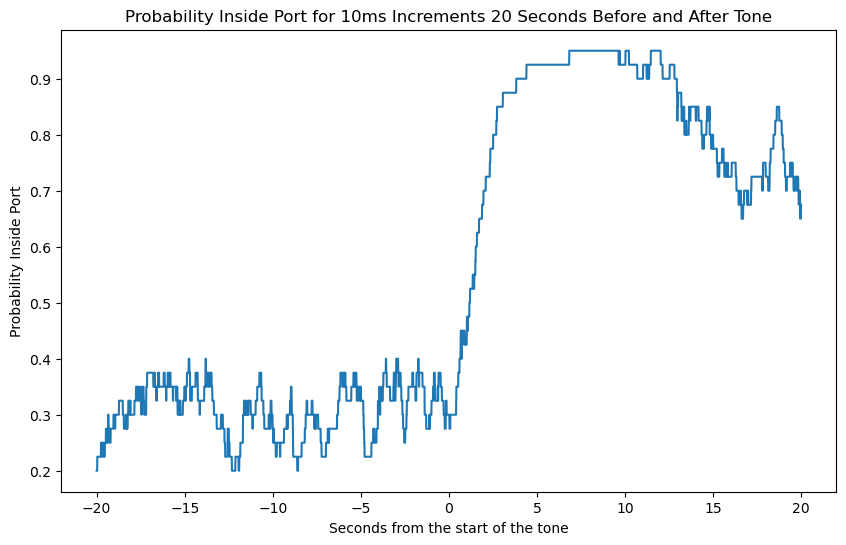

In [53]:
plt.plot(np.linspace(-20,20,4000), mean_example_all_tone_time_masks)
plt.xlabel("Seconds from the start of the tone")
plt.ylabel("Probability Inside Port")
plt.title("Probability Inside Port for 10ms Increments 20 Seconds Before and After Tone")

# 4. Plotting for Multiple Training Sessions

## 4.1 Checking Which Sessions Have Valid Tone Times

In [54]:
concatted_medpc_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,file_path
0,439.08,64.0,399.0,0.0,60.01,439.10,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...
1,439.13,489.0,399.0,0.0,140.01,449.23,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...
2,677.76,754.0,399.0,0.0,230.01,678.31,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...
3,678.49,944.0,399.0,0.0,310.01,683.61,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...
4,851.64,1329.0,399.0,0.0,385.01,856.41,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...


- Getting all the files with valid tone times. Some files were for testing and do not have the times that the tones were played

In [55]:
valid_files = []
for file_path in recording_and_metadata_df["file_path"].unique():
    current_medpc_df = recording_and_metadata_df[recording_and_metadata_df["file_path"] == file_path]
    valid_tones = processing.tone.get_valid_tones(tone_pd_series= current_medpc_df["(S)CSpresentation"])

    if not valid_tones.empty:
        valid_files.append(file_path)
    else:
        print("Skipped {}".format(key))

/nancy/projects/behavioral_dataframe_processing/jupyter_notebooks/MED_PC/../../src/processing/tone.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tone_pd_series = tone_pd_series[:max_tone_index]


In [56]:
valid_files[:5]

['./example_recordings/2022-05-09_09h48m_Subject 1.1.txt',
 './example_recordings/2022-05-11_15h25m_Subject 2.2.txt',
 './example_recordings/2022-05-08_09h49m_Subject 2.3.txt',
 './example_recordings/2022-05-11_15h25m_Subject 2.3.txt',
 './example_recordings/2022-05-10_15h58m_Subject 1.1.txt']

- Getting all rows that meet the criteria of being from a vile with valid tone times

In [57]:
valid_files_df = recording_and_metadata_df[recording_and_metadata_df["file_path"].isin(valid_files)]

In [58]:
valid_files_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
12705,4.46,64.0,399.0,0.0,60.01,5.03,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12706,53.73,144.0,399.0,0.0,140.01,59.77,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12707,61.61,234.0,399.0,0.0,230.01,73.37,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12708,77.85,314.0,399.0,0.0,310.01,80.71,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12709,95.26,389.0,399.0,0.0,385.01,99.79,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1


In [59]:
valid_files_df.tail()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
185488,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220511,1.1,...,05/11/22,05/12/22,1.1,Pilot of Pilot,Cage 1,1,15:25:43,10:08:20,levelNP_CS_reward_laserepochON1st_noshock,1
185489,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220511,1.1,...,05/11/22,05/12/22,1.1,Pilot of Pilot,Cage 1,1,15:25:43,10:08:20,levelNP_CS_reward_laserepochON1st_noshock,1
185490,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220511,1.1,...,05/11/22,05/12/22,1.1,Pilot of Pilot,Cage 1,1,15:25:43,10:08:20,levelNP_CS_reward_laserepochON1st_noshock,1
185491,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220511,1.1,...,05/11/22,05/12/22,1.1,Pilot of Pilot,Cage 1,1,15:25:43,10:08:20,levelNP_CS_reward_laserepochON1st_noshock,1
185492,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220511,1.1,...,05/11/22,05/12/22,1.1,Pilot of Pilot,Cage 1,1,15:25:43,10:08:20,levelNP_CS_reward_laserepochON1st_noshock,1


## 4.2 Going through Each Subject and Each Day to Get the Average Probability of All the Time Increments Across All Trials

- We will be doing what we did for all the subjects and dates now

In [60]:
subject_to_date_to_average_probability = defaultdict(dict)
# Going through each subject
for subject in recording_and_metadata_df["subject"].unique():
    # Getting all the rows that are for one subject 
    one_subject_all_days = recording_and_metadata_df[recording_and_metadata_df["subject"] == subject]
    
    # Going through each date of one subject
    for date in one_subject_all_days["date"].unique():
        # Getting all the rows that correspond to the date
        one_day_df = one_subject_all_days[one_subject_all_days["date"] == date].copy()
        ### Scaling all the dataframes
        one_day_df["port_entry_scaled"] = one_day_df["(P)Portentry"].apply(lambda x: processing.port.scale_time_to_whole_number(x))
        one_day_df["port_exit_scaled"] = one_day_df["(N)Portexit"].apply(lambda x: processing.port.scale_time_to_whole_number(x))
        one_day_df["tone_start_scaled"] = one_day_df["(S)CSpresentation"].apply(lambda x: processing.port.scale_time_to_whole_number(x))
        
        ### All the numbers of times inside port
        one_day_entry_times = processing.port.get_all_port_entry_increments(port_entry_scaled=one_day_df["port_entry_scaled"], port_exit_scaled=one_day_df["port_exit_scaled"])
        ### Getting all the valid tone times and the max tone time
        one_day_valid_tone_times = processing.tone.get_valid_tones(tone_pd_series=one_day_df["tone_start_scaled"]).astype(int)
        one_day_max_time = one_day_valid_tone_times.max() + 2001
        ### Getting a mask of all the times in the port
        one_day_experiment_interval, one_day_entry_mask = processing.port.get_inside_port_mask(max_time=one_day_max_time, inside_port_numbers=one_day_entry_times)
        ### Getting the average probability
        one_day_average_all_tone_time_masks = processing.port.get_inside_port_probability_averages_for_all_increments(tone_times=one_day_valid_tone_times, inside_port_mask=one_day_entry_mask)
        subject_to_date_to_average_probability[subject][date] = one_day_average_all_tone_time_masks


/nancy/projects/behavioral_dataframe_processing/jupyter_notebooks/MED_PC/../../src/processing/tone.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tone_pd_series = tone_pd_series[:max_tone_index]
/nancy/projects/behavioral_dataframe_processing/jupyter_notebooks/MED_PC/../../src/processing/tone.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tone_pd_series = tone_pd_series[:max_tone_index]
/nancy/projects/behavioral_dataframe_processing/jupyter_notebooks/MED_PC/../../src

In [61]:
for key, value in subject_to_date_to_average_probability.items():
    print("Subject: {}".format(key))
    print("Date to probability inside port for each increment: {}".format(value))
    break

Subject: 1.1
Date to probability inside port for each increment: {20220509: array([0.2  , 0.2  , 0.2  , ..., 0.675, 0.675, 0.675]), 20220510: array([0.675, 0.675, 0.675, ..., 0.45 , 0.45 , 0.475]), 20220508: array([0.17948718, 0.17948718, 0.20512821, ..., 0.69230769, 0.69230769,
       0.69230769]), 20220511: array([0.575, 0.575, 0.575, ..., 0.75 , 0.775, 0.775])}


In [62]:
subject_to_date_to_average_probability["3.3 (4)"]

{}

In [63]:
subject_to_cage = pd.Series(metadata_df["cage"].values.astype(int),index=metadata_df["Subject"].values).to_dict()

In [64]:
subject_to_cage

{1.3: 2, 2.1: 2, 2.2: 1, 1.1: 1, 1.2: 2, 2.4: 2, 1.4: 1, 2.3: 1}

- Making directories for output

In [65]:
probability_inside_port_plots_output_directory = "./proc/plots/probability_inside_port/cage_{}_date_{}_{}".format(cage_numbers_for_title, earliest_date, latest_date)

In [66]:
probability_inside_port_plots_output_directory

'./proc/plots/probability_inside_port/cage_1_date_20220508_20220512'

In [67]:
os.makedirs(probability_inside_port_plots_output_directory, exist_ok=True)

## Plotting the probability that the subject is in the port for a given time increment before or after the tone

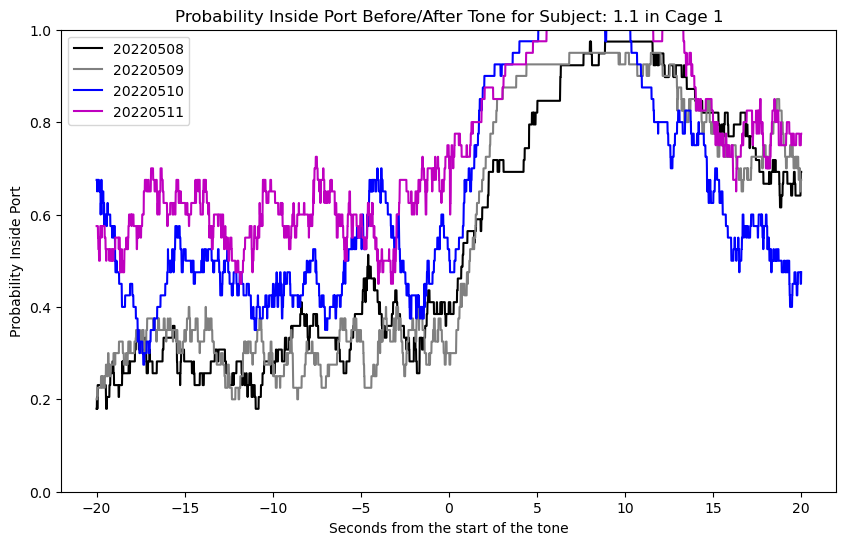

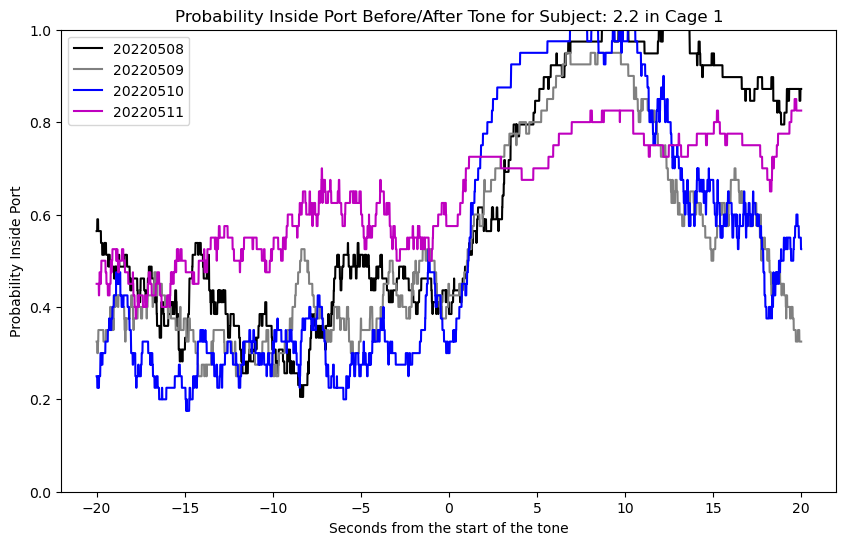

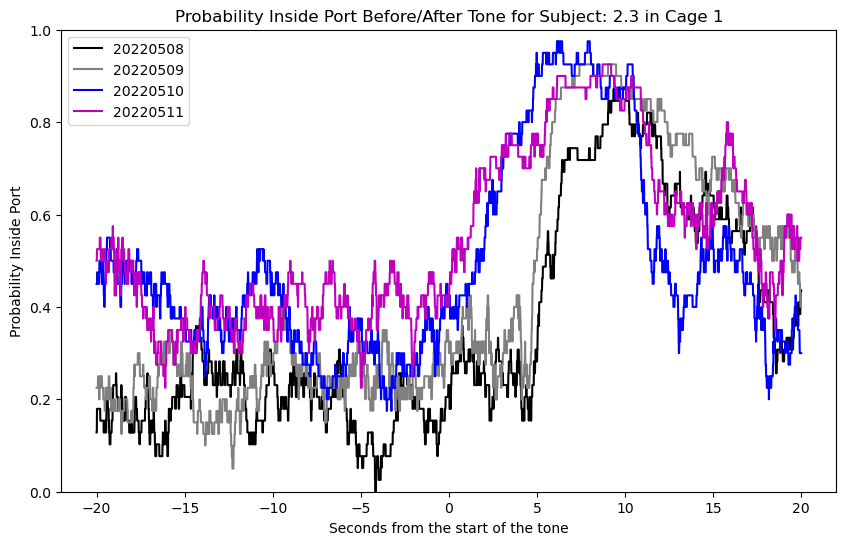

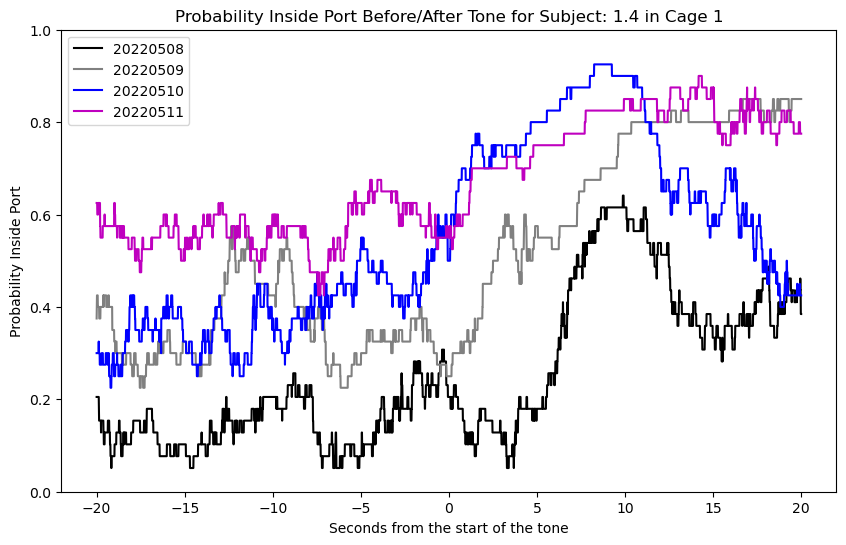

In [68]:
all_colors = ["k", "gray", "b", "m", "fuchsia", "c","g", "lime", "y", "darkorange", "r", "deeppink"]
for subject_id in recording_and_metadata_df["subject"].unique():
    fig, ax = plt.subplots()
    cage = int(subject_to_cage[subject_id])
    ax.set_xlabel("Seconds from the start of the tone")
    ax.set_ylabel("Probability Inside Port")
    ax.set_title("Probability Inside Port Before/After Tone for Subject: {} in Cage {}".format(subject_id, cage))
    counter = 0

    for key in sorted(subject_to_date_to_average_probability[subject_id].keys()):
        ax.plot(np.linspace(-20,20,4000), subject_to_date_to_average_probability[subject_id][key], label=key, color=all_colors[counter])
        counter += 1
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.set_ylim(0, 1)
    ax.legend(handles, labels)

    file_name = "probability_inside_port_cage_{}_subject_{}_date_{}_{}.png".format(cage, subject_id, earliest_date, latest_date)
    plt.savefig(os.path.join(probability_inside_port_plots_output_directory, file_name))

# 4. Licking Specifity Average

- Licking specifity is measured by getting that average probability for all time increments that the subject is in a port from either -20 to 0 seconds from the tone playing or 0 to 10 seconds from the tone playing. The goal will be to more easily compare if the subject is correctly associating the tone with the reward by comparing how often they're in the port before and after the tone.

- Getting the mean of all the port probabilites for each subject + date combination for -20 to 0 seconds from the tone playing or 0 to 10 seconds from the tone playing.

In [69]:
subject_to_date_to_licking_specificty = defaultdict(lambda: defaultdict(dict))
for subject, all_dates in subject_to_date_to_average_probability.items():
    for date, averages in all_dates.items():
        subject_to_date_to_licking_specificty[subject][date]["-20_to_0"] = averages[0:2000].mean()
        subject_to_date_to_licking_specificty[subject][date]["0_to_10"] = averages[2000:3000].mean()

In [70]:
for key, value in subject_to_date_to_licking_specificty.items():
    print("Subject: {}".format(key))
    print("Date to licking specifity before and after tone: {}".format(value))
    break

Subject: 1.1
Date to licking specifity before and after tone: defaultdict(<class 'dict'>, {20220509: {'-20_to_0': 0.30695, '0_to_10': 0.821}, 20220510: {'-20_to_0': 0.47636249999999997, '0_to_10': 0.9103}, 20220508: {'-20_to_0': 0.31156410256410255, '0_to_10': 0.7757435897435897}, 20220511: {'-20_to_0': 0.5971375000000001, '0_to_10': 0.9236749999999999}})


- Turning the dictionary into dataframe for plotting

In [71]:
licking_specifity_df = pd.DataFrame.from_dict({(i,j): subject_to_date_to_licking_specificty[i][j] 
                           for i in subject_to_date_to_licking_specificty.keys() 
                           for j in subject_to_date_to_licking_specificty[i].keys()},
                       orient='index')


- Adding metadata and formatting the dataframe

In [72]:
licking_specifity_df = licking_specifity_df.reset_index()
licking_specifity_df = licking_specifity_df.rename(columns={"level_0": "subject", "level_1": "date"})

In [73]:
licking_specifity_df["date_int"] = licking_specifity_df["date"].astype(int)
licking_specifity_df["cage"] = licking_specifity_df["subject"].map(subject_to_cage)

In [74]:
licking_specifity_df

,subject,date,-20_to_0,0_to_10,date_int,cage
0,1.1,20220509,0.306950,0.821000,20220509,1
1,1.1,20220510,0.476362,0.910300,20220510,1
2,1.1,20220508,0.311564,0.775744,20220508,1
3,1.1,20220511,0.597138,0.923675,20220511,1
4,2.2,20220511,0.537025,0.735025,20220511,1
5,2.2,20220510,0.304488,0.857350,20220510,1
6,2.2,20220508,0.410513,0.788872,20220508,1
7,2.2,20220509,0.373762,0.780475,20220509,1
8,2.3,20220508,0.184821,0.471590,20220508,1
9,2.3,20220511,0.400462,0.764650,20220511,1


In [75]:
licking_specifity_df = licking_specifity_df.sort_values(by=["subject", "date_int"])

In [76]:
licking_specifity_df = licking_specifity_df.reset_index(drop=True)

- Making Directories

In [77]:
subject_and_date_rows_licking_specifity_output_directory = "./proc/subject_and_date_rows_licking_specifity_output_directory/cage_{}_date_{}_{}".format(cage_numbers_for_title, earliest_date, latest_date)

In [78]:
subject_and_date_rows_licking_specifity_output_directory

'./proc/subject_and_date_rows_licking_specifity_output_directory/cage_1_date_20220508_20220512'

In [79]:
os.makedirs(subject_and_date_rows_licking_specifity_output_directory, exist_ok=True)

- Saving the dataframe to a file

In [80]:
licking_specifity_df.to_csv(os.path.join(subject_and_date_rows_licking_specifity_output_directory, "lsubject_and_date_rows_licking_specifity_cage_{}_date_{}_{}.csv".format(cage_numbers_for_title, earliest_date, latest_date)))
licking_specifity_df.to_excel(os.path.join(subject_and_date_rows_licking_specifity_output_directory, "lsubject_and_date_rows_licking_specifity_cage_{}_date_{}_{}.xlsx".format(cage_numbers_for_title, earliest_date, latest_date)))


## Plotting the Licking Specifity

- Making the output directories

In [81]:
licking_specifity_plots_output_directory = "./proc/plots/licking_specifity/cage_{}_date_{}_{}".format(cage_numbers_for_title, earliest_date, latest_date)

In [82]:
licking_specifity_plots_output_directory

'./proc/plots/licking_specifity/cage_1_date_20220508_20220512'

In [83]:
os.makedirs(licking_specifity_plots_output_directory, exist_ok=True)

- Creating the plots

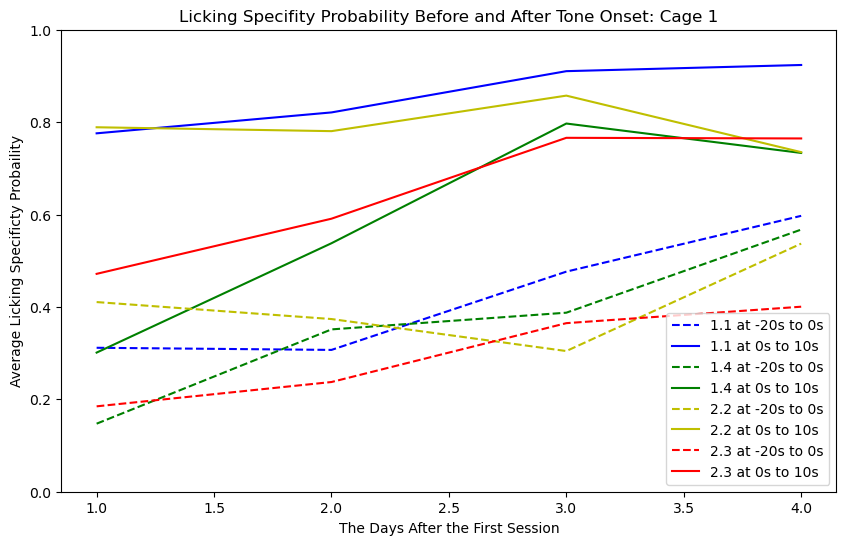

In [84]:
all_colors = ["b", "g", "y", "r"]

for cage in licking_specifity_df["cage"].unique():
    fig, ax = plt.subplots()

    cage_df = licking_specifity_df[licking_specifity_df["cage"] == cage]
    counter = 0
    for subject in cage_df["subject"].unique():
        subject_df = cage_df[cage_df["subject"] == subject]
        
        
        ax.plot(subject_df["date_int"] - subject_df["date_int"].min() + 1, subject_df["-20_to_0"], '--', color=all_colors[counter], label="{} at -20s to 0s".format(subject))
        ax.plot(subject_df["date_int"] - subject_df["date_int"].min() + 1, subject_df["0_to_10"], '-', color=all_colors[counter], label="{} at 0s to 10s".format(subject))
        counter += 1
        
    ax.set_xlabel("The Days After the First Session")
    ax.set_ylabel("Average Licking Specificty Probaility")
    ax.set_title("Licking Specifity Probability Before and After Tone Onset: Cage {}".format(int(cage)))

    ax.set_ylim(0, 1)
    ax.legend()
    
    file_name = "licking_specifity_plot_cage_{}_date_{}_{}.png".format(int(cage), earliest_date, latest_date)
    plt.savefig(os.path.join(licking_specifity_plots_output_directory, file_name))
    